In [1]:
from bloch.utils import *
from bloch.epg_transforms import *

import autograd.numpy as np
# no GPUs
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=''

import tensorflow as tf

import scipy.optimize

import matplotlib.pyplot as plt
import time as time

%load_ext autoreload
%autoreload 2

%matplotlib notebook

/home/pkllee/anaconda2/envs/tf3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=''


In [2]:
def make_despot1_tf_graph(do_log=False, do_ratio_correction=True):    
    
    despot1_tf_graph = tf.Graph()
    
    with despot1_tf_graph.as_default():
        # declare constant sequence parameters
        N = 400 # number of TRs to simulate
        N_stop = -1 # point at which to stop the gradient propagation
        M0_var = tf.Variable(1.0, name='M0')
        
        T1_var, T2_var = (tf.Variable(1645., name='T1'), tf.Variable(50., name='T2'))
        TR = tf.constant(10., name='TR')        
        TE = tf.constant(5., name='TE')
        
              
        # declare some helper functions
        def phi_k(k): # quadratic phase in degrees
            phi = 117. * k * (k + 1.)/2.
            return tf.constant(phi)
        
        def tf_concat_echos(echos, FZ_echo):
            with tf.name_scope('concat_echo') as scope:
                echo = tf.expand_dims(tf.real(tf_FZ0_to_M(FZ_echo))[:, 0], 1) # to make same size as M_echos
                echos = tf.concat((echos, echo), axis=1)                
            return echos
        
        def tf_echo_intensity(a, b):
            with tf.name_scope('intensity'):
                 out = tf.sqrt(a * a + b * b)
            return out
        
        def tf_sind(angle):
            with tf.name_scope('sind'):
                out = tf.sin(angle * np.pi/180.)
            return out
        
        def tf_tand(angle):            
            with tf.name_scope('tand'):
                out = tf.tan(angle * np.pi/180.)
            return out

        # create variables to optimize over
        alpha1_var = tf.Variable(0., name='alpha1')
        alpha2_var = tf.Variable(0., name='alpha2')
        # Since we simulate the same sequence twice for two different alphas, it makes sense to have a function
        # that builds a graph for one despot1 acquisition
        #
        # Recycle the relax_TE, relax_TR_minus_TE, and grad_FZ operators to slightly reduce the size of the graph
        # The RF cannot be recycled because the phi changes quadratically
        #
        # @params alpha_var tf variable with the value for flip in degrees
        def tf_simulate_despot1(alpha_var): 
            M_echos = tf.zeros([3, 1])
            with tf.name_scope('despot1_acq') as scope:
                # build computation graph
                FZ_init = tf_get_FZ_init(M0_var)        
                FZ_preflip = FZ_init 
                
                f_relax_TE = tf_get_relax_epg(M0_var, TE, T1_var, T2_var)
                f_relax_TR_minus_TE = tf_get_relax_epg(M0_var, TR - TE, T1_var, T2_var)

                # simulate sequence for alpha
                for ii in range(0, N):
                    with tf.name_scope('despot1_TR') as scope:
                        phi = phi_k(ii)

                        FZ_1 = tf_rf_FZ(FZ_preflip, alpha_var, phi)   
                        
                        """ Explicit operators with no reuse of relax operator """
                        #FZ_echo = tf_relax_FZ(FZ_1, M0, TE, T1, T2)  # accumulated time = TE
                        #FZ_preflip = tf_grad_FZ(tf_relax_FZ(FZ_echo, M0, TR - TE, T1, T2)) # accumulated time = TR                       
                        
                        """ Reuse relax operator to reduce graph size"""
                        FZ_echo = f_relax_TE(FZ_1)
                        FZ_preflip = tf_grad_FZ(f_relax_TR_minus_TE(FZ_echo))

                        M_echos = tf_concat_echos(M_echos, FZ_echo)
            return M_echos
                
        M_echos_1 = tf_simulate_despot1(alpha1_var)
        M_echos_2 = tf_simulate_despot1(alpha2_var)
        M_ss_1 = tf_echo_intensity(M_echos_1[0, -1], M_echos_1[1, -1])
        M_ss_2 = tf_echo_intensity(M_echos_2[0, -1], M_echos_2[1, -1])
        
        with tf.name_scope('estimate_T1') as scope:
            R = (M_ss_2/tf_sind(alpha2_var) - M_ss_1/tf_sind(alpha1_var))
            S = (M_ss_2/tf_tand(alpha2_var) - M_ss_1/tf_tand(alpha1_var))
            ratio_image = R/S                            
                            
            T1_guess = -TR / tf.log(ratio_image)            

        with tf.name_scope('crb') as scope:
            if(do_ratio_correction):
                J = tf.gradients(ratio_image, T1_var, name='dM_dtiss_param') # tf gradients returns a list
                fim = J[0] * J[0] # fischer information matrix
                V = 1. / fim            

                # similar to DESS ratio correction, but includes a bias term since the numerator and denominator noise
                # are correlated Z = R/S
                sigma_squared_R = tf.square(1./tf_sind(alpha2_var)) + tf.square(1./tf_sind(alpha1_var))
                sigma_squared_S = tf.square(1./tf_tand(alpha2_var)) + tf.square(1./tf_tand(alpha1_var))
                cov_RS = 1./(tf_sind(alpha2_var) * tf_tand(alpha2_var)) + 1./(tf_sind(alpha1_var) * tf_tand(alpha1_var))

                ratio_correction = tf.square(R)/tf.square(S) * \
                (sigma_squared_R/tf.square(R) + sigma_squared_S/tf.square(S) - \
                 2. * cov_RS/(S * R))

                crb = V * ratio_correction
            else:
                J1_M0 = tf.gradients(M_ss_1, M0_var, name='dM1_dM0')[0] # have to split gradients calls since TF sums them
                J2_M0 = tf.gradients(M_ss_2, M0_var, name='dM2_dM0')[0]

                J1_T1 = tf.gradients(M_ss_1, T1_var, name='dM1_dT1')[0]
                J2_T1 = tf.gradients(M_ss_2, T1_var, name='dM2_dT1')[0]

                fim = tf.convert_to_tensor([[J1_M0 * J1_M0, J1_T1 * J1_M0], [J1_M0 * J1_T1, J1_T1 * J1_T1]]) + \
                      tf.convert_to_tensor([[J2_M0 * J2_M0, J2_M0 * J2_T1], [J2_T1 * J2_M0, J2_T1 * J2_T1]])

                crb = tf.trace(tf.linalg.inv(fim))
       
        if(do_log):
            tf.summary.FileWriter('./tmp/', despot1_tf_graph)      
            
        despot1_graph_session = tf.Session()
        
        def run_despot1_tf_graph(T1, T2, alpha1, alpha2, tensors_to_eval):
            alpha1_assign_op = alpha1_var.assign(alpha1)
            alpha2_assign_op = alpha2_var.assign(alpha2)
            
            T1_assign_op = T1_var.assign(T1)
            T2_assign_op = T2_var.assign(T2)

            M0_assign_op = M0_var.assign(1.0)
            
            with despot1_tf_graph.as_default():
                despot1_graph_session.run([M0_assign_op, alpha1_assign_op, alpha2_assign_op, T1_assign_op, T2_assign_op])                
                out = despot1_graph_session.run(tensors_to_eval)

            return out
        
        def crb_obj(T1, T2, alpha1, alpha2):            
            tensors_to_eval = [T1_guess, crb]
            T1_guess_eval, crb_eval = run_despot1_tf_graph(T1, T2, alpha1, alpha2, tensors_to_eval)
            
            return T1_guess_eval, crb_eval
        
        def despot1_get_M(T1, T2, alpha1, alpha2): # just does the bloch simulation
            M_echos_1_eval, M_echos_2_eval, T1_guess_eval = run_despot1_tf_graph(T1, T2, alpha1, alpha2, [M_echos_1, M_echos_2, T1_guess])
            return M_echos_1_eval, M_echos_2_eval, T1_guess_eval
        
        def despot1_debug(T1, T2, alpha1, alpha2): # for choosing specific tensors            
            out = run_despot1_tf_graph(T1, T2, alpha1, alpha2, cov_RS)
            return out
                
    
    return despot1_get_M, crb_obj, despot1_debug
        
        

In [3]:
ratio_correction = False    
do_log = False
despot1_get_M, crb_obj, despot1_debug = make_despot1_tf_graph(do_log, ratio_correction)

In [4]:
alpha1 = 1.85
alpha2 = 10.75
#T1_graymatter = 1331.
#T2_graymatter = 80.

T1 = 1645. # values used in manuscript
T2 = 50.

#out = despot1_debug(T1_graymatter, T2_graymatter, alpha1, alpha2)
#print(out)
print('N_states : ' + str(get_N_states_epg()))

N_states : 10


##  Plot echos

In [5]:
alpha1 = 1.85
alpha2 = 10.75

M_echos_1_eval, M_echos_2_eval, T1_guess_eval = despot1_get_M(T1, T2, alpha1, alpha2)
_, crb_eval = crb_obj(T1, T2, alpha1, alpha2)

Estimated T1:
1682.3345
CRB:
10692303000.0
Steady State S1:
0.027090782487562453
Steady State S2:
0.043160142810474166


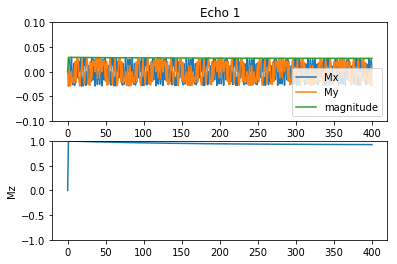

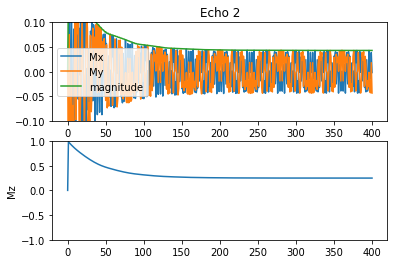

In [6]:
# M_echos should be a 3xN np array
def plot_echos(M_echos, title=''):
    
    def plot_train(_y, _y_label='', _y_lim=[-1, 1]):
        plt.plot(_y)
        plt.ylim(_y_lim)
        plt.ylabel(_y_label)
    
    plt.figure()
    plt.subplot(211)    
    plot_train(M_echos[0, :])
    plot_train(M_echos[1, :])
    plot_train(np.sqrt(np.power(M_echos[0, :], 2) + np.power(M_echos[1, :], 2)), _y_lim=[-0.1, 0.1]) # only ylim last plot
    plt.title(title)
    plt.legend(['Mx', 'My', 'magnitude'])
    plt.subplot(212)
    plot_train(M_echos[2, :], 'Mz')
    
    plt.show()

print('Estimated T1:')    
print(T1_guess_eval)  
print('CRB:')
print(crb_eval)
print('Steady State S1:')
print(np.sqrt(np.power(M_echos_1_eval[0, -1], 2) + np.power(M_echos_1_eval[1, -1], 2)))
print('Steady State S2:')
print(np.sqrt(np.power(M_echos_2_eval[0, -1], 2) + np.power(M_echos_2_eval[1, -1], 2)))
    
plot_echos(M_echos_1_eval, 'Echo 1')
plot_echos(M_echos_2_eval, 'Echo 2')

# 1D CRB Plot

In [7]:
# 1D plot
alpha1s = np.linspace(5, 18, num=15)
alpha2 = 1.85

T1_guess_list = []
crb_list = []
for alpha1 in alpha1s:
    T1_guess_eval, crb_eval = crb_obj(T1, T2, alpha1, alpha2)
    
    T1_guess_list.append(T1_guess_eval)
    crb_list.append(crb_eval)

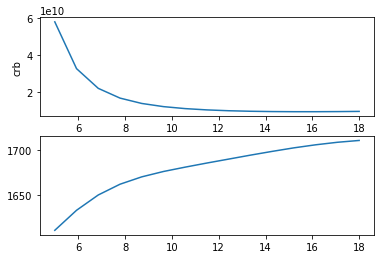

In [8]:
plt.figure()
plt.subplot(211)
plt.plot(alpha1s, crb_list)
plt.ylabel('crb')
plt.subplot(212)
plt.plot(alpha1s, T1_guess_list)

## Make wrapper for crb objective function

In [9]:
do_timer = False

# make a wrapper, which accepts a numpy array, with order [alpha1, alpha2], args must be a tuple (T1, T2)
def crb_obj_wrapper(x, *args):    
    T1, T2 = args
    
    start = time.time()
    _, crb_eval = crb_obj(T1, T2, x[0], x[1])   
    crb_eval = crb_eval / 1e7 # need to divide by constant so that numerical gradient is within reasonable range
    
    if(do_timer):
        print('time: ' + str(time.time() - start))
        print(x)
        print('crb: ' + str(crb_eval))            
    
    return crb_eval

## Do Optimization

In [ ]:
start_time = time.time()

# makes sure flip angles have a difference > X (avoids low snr in difference)
def flip_angle_ieqcons(x, *args):
    flip_angle_difference = 2.
    return (np.abs(x[0] - x[1]) - flip_angle_difference) 

def slsqp_callback(x):
    print('alpha : ' + str(x))
        
# optimize jointly over alpha1, alpha2
K = 5
x_init_alpha_1_sweep = np.linspace(1., 19., num=K)
x_init_alpha_2_sweep = np.linspace(7., 23., num=K) # don't initialize with same alphas or there are nans

args_in = (T1, T2)


x_optimal_list = np.array([[0], [0]])
fx_optimal_list = np.array([0])

# use a double for loop so that we don't repeat combinations
for ii in range(0, K):
    for jj in range(ii, K):

        x_init = np.array([x_init_alpha_1_sweep[ii], x_init_alpha_2_sweep[jj]]) # degrees
        
        print('X_init_alpha ii: ' + str(ii) + ' jj: ' + str(jj) + ' ' + str(x_init))        
        
        x_bounds = [(1., 25.), (1., 25.)] # degrees

        optimize_args = {'bounds': x_bounds, 'iprint': 2, 'epsilon': 0.1, 
                         'ieqcons': [flip_angle_ieqcons], 'callback':slsqp_callback, 'iter': 10} # epsilon is step size in degrees
        #optimize_args = {'iprint': 2, 'epsilon': 0.1}

        x_optimal, fx, its, imode, smode = scipy.optimize.fmin_slsqp(crb_obj_wrapper, 
                                  x_init,
                                  **optimize_args,
                                  args=args_in,
                                  full_output=True)

        alpha_1_opt = x_optimal[0]
        alpha_2_opt = x_optimal[1]

        x_optimal_list = np.concatenate((x_optimal_list, x_optimal[:, np.newaxis]), axis=1)
        fx_optimal_list = np.concatenate((fx_optimal_list, np.array([fx])), axis=0)
        
        print('Solution')
        print(x_optimal)
        
        T1_guess, _ = crb_obj(T1, T2, x_optimal[0], x_optimal[1])
        print('Guessed T1:')
        print(T1_guess)

elapsed_time = time.time() - start_time
print(elapsed_time)

X_init_alpha ii: 0 jj: 0 [1. 7.]
  NIT    FC           OBJFUN            GNORM
alpha : [23.00003279 25.        ]
    1     4     4.593712E+03     6.554614E+03
alpha : [ 1.         23.46986677]
    2     9     1.145124E+03     2.906126E+02


In [ ]:
T1_guess, obj = crb_obj(T1, T2, 1.85, 10.75)
print((T1_guess, obj))

In [15]:
elapsed_time

5666.137354850769

In [16]:
fx_optimal_list_cut = fx_optimal_list[1::]
x_optimal_list_cut = x_optimal_list[:, 1::]
min_index = np.argmin(fx_optimal_list_cut)
print(min_index)
best_solution = x_optimal_list_cut[:, min_index]
print(best_solution)

6
[ 2.7911598  14.51538882]


## Surface plot

In [ ]:
# surface plot
#KK = 38 # number of grid points on surf plot
KK = 5
alpha1s = alpha2s = np.linspace(1., 20., num=KK)
X, Y = np.meshgrid(alpha1s, alpha2s)

Z = np.ones_like(X)

for xx in range(0, KK):
    for yy in range(0, KK):
        #if(xx > yy): # avoid where alphas are equal (gives nans), and the plot is symmetrical so use >
        _angles = np.array([X[xx, yy], Y[xx, yy]])
        Z[xx, yy] = crb_obj_wrapper(_angles, *(T1, T2))

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, np.log10(Z))

ax.set_xlabel('alpha1')
ax.set_ylabel('alpha2')
ax.set_zlabel('crb')

plt.title('log10 of crb')

plt.show()